In [1]:
from IPython.display import display, Markdown
from os import listdir
from os.path import isfile, join
# import numpy as np
# import pandas as pd

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_colwidth', -1)

# Pretty display for notebooks
%matplotlib inline
fontdict = {'fontsize':20, 'fontweight':'bold'}

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class Model:
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self.__build_net()
        
    def __build_net(self):
        # tf 내부에는 variable가 작용하는 scope가 있다. 이 클래스를 호출한 변수명으로 이 범위가 지정되게 된다.
        with tf.variable_scope(self.name):
            self.keep_prob = tf.placeholder(tf.float32)
            self.X = tf.placeholder(shape=[None, 784], dtype=tf.float32)
            self.y = tf.placeholder(shape=[None, 10], dtype=tf.float32)
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            
            W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
            L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding="SAME")
            L1 = tf.nn.relu(L1)
            L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
            L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
            
            W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
            L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding="SAME")
            L2 = tf.nn.relu(L2)
            L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
            L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)
            
            W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
            L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding="SAME")
            L3 = tf.nn.relu(L3)
            L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
            L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)
            
            L3_flat = tf.reshape(L3, [-1, 4*4*128])
            
            W4 = tf.get_variable("W4", shape=[4*4*128, 625], initializer=tf.contrib.layers.xavier_initializer())
            b4 = tf.Variable(tf.random_normal([625]))
            L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
            L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
            
            W5 = tf.get_variable("W5", shape=[625, 10], initializer=tf.contrib.layers.xavier_initializer())
            b5 = tf.Variable(tf.random_normal([10]))
            
            # hypothesis에 해당하는 logit은 재사용할 것이므로 self 객체내에 저장한다.
            self.logits = tf.matmul(L4, W5) + b5
            
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logit, labels=self.y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def predict(self, x_test, keep_prob=1.0):
        return self.sess.run(self.logits, feed_dict={self.X:x_test, self.keep_prob: keep_prob})
        
    def get_accuracy(self, x_test, y_test):
        return self.sess.run(self.accuracy, feed_dict={self.X:x_test, self.y:y_test, self.keep_prob:keep_prob})
    
    def train(self, x_train, y_train, keep_prob=0.7):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_train, self.y: y_train, self.keep_prob: keep_prob})

In [306]:
asset_path = "./asset/"

def get_dfs(path):
    dirs = [f for f in listdir(path) if not isfile(join(path, f))]
    dict_2017 = {}
    dict_2018 = {}
    is_there_2017 = False
    for idx, dir_ in enumerate(dirs):
        df_path = path + dir_ + "/"
        files = [f for f in listdir(df_path) if isfile(join(df_path, f)) and "csv" in f]
        for idx_, file in enumerate(files):
            file_path = df_path + file
            df = pd.read_csv(file_path, encoding="ISO-8859-1")
            if idx > 0 and idx_ == 0:
                display(Markdown("---"))
            display(Markdown(dir_.split("-")[-1] + " _**" + file + "**_ has <span style='color:blue'>"
                             + str(df.shape) + "</span> shape of data."))
            if "2017" in dir_:
                dict_2017[file.split(".")[0]] = df
                is_there_2017 = True
            else:
                dict_2018[file.split(".")[0]] = df
    
    if is_there_2017:
        return dict_2017, dict_2018
    else:
        return dict_2018

def print_question(year, col, cols=[], is_survey_schema=False, is_need_result = False):
    if is_survey_schema:
        tmp_df = pd.read_csv(asset_path + "surveySchema_18.csv")
        print(tmp_df[col].iloc[0])
        print("here")
        return 
    dir_name = "kaggle-survey-"
    tmp_df = pd.DataFrame([])
    result = ""
    if year == 2017:
        tmp_df = pd.read_csv(asset_path + dir_name + "2017/schema.csv")
    else:
        tmp_df = pd.read_csv(asset_path + "/schema_new.csv")
        tmp_df.columns = ["Column", "Question"]
    tmp_df = tmp_df.set_index("Column")
    result = tmp_df.loc[col]["Question"]
    if is_need_result:
        return result
    else:
        print(col)
        if len(cols) == 0:
            print(result)
    
def get_question_list():
    dir_name = "kaggle-survey-"
    
    tmp_df = pd.read_csv(asset_path + dir_name + "2017/schema.csv")
    tmp_df = tmp_df.set_index("Column")
    q_2017 = tmp_df["Question"].unique().tolist()

    tmp_df = pd.read_csv(asset_path + "/schema_new.csv")
    tmp_df.columns = ["Column", "Question"]
    tmp_df = tmp_df.set_index("Column")
    q_2018 = tmp_df["Question"].unique().tolist()
    
    return q_2017, q_2018

def make_question_list(single_choice, multiple_choice):
    tmp_df = pd.read_csv(asset_path + "/schema_new.csv")
    tmp_df.columns = ["Column", "Question"]
    tmp_df = tmp_df.set_index("Column")
    q_list = []
    q_len = len(single_choice) + len(multiple_choice)
    is_single_choice_list = []
    for i in range(q_len):
        is_single = 1
        q_txt = "Q" + str(i + 1)
        if q_txt in multiple_choice:
            q_txt = q_txt + "_Part_1"
            is_single = 0
        try:
            q = tmp_df.loc[q_txt]["Question"]
        except:
            q_txt = q_txt + "_TEXT"
            q = tmp_df.loc[q_txt]["Question"]
        q_list.append(q)
        is_single_choice_list.append(is_single)
    return q_list, is_single_choice_list

def get_question(df, number, is_need_display_order = False):
    tmp = df.loc[number]
    if tmp["is_single"] == 1:
        q = tmp["question"]
        print("Q" +str(number) + ".", df.loc[number]["question"])
    else:
        tmp_li = get_selections_of_multiple_choice_question(number)
        display_order = []
        for idx, q in enumerate(tmp_li):
            if "_OTHER_TEXT" not in q:                
                q_ = print_question(2018, q, is_need_result=True).split("-")
                display_order.append(q_[-1].strip())
                if idx == 0:
                    print(q.split("_")[0] + ".", q_[0])
                    print(" ", str(idx + 1) + ".", q_[-1])
                else:
                    print(" ", str(idx + 1) + ".", q_[-1])
        if is_need_display_order:
            return display_order

def get_selections_of_multiple_choice_question(number):
    tmp_df = pd.read_csv(asset_path + "/schema_new.csv")
    tmp_df.columns = ["Column", "Question"]
    tmp_df = tmp_df.set_index("Column")
    tmp_li = [ 
        q_ for q_ in 
        (q for q in tmp_df.index.tolist() if str(number) in q) 
        if str(number) in q_.split("_")[0]
    ]
    return tmp_li
        
def get_df_i_want(df, col, condition, is_false = False):
    return df[df[col] != condition] if is_false else df[df[col] == condition]
        
def per_df(df, col) :
    val_cnt = df[col].value_counts() 
    return val_cnt / val_cnt.sum()
    
def save_csv(df, filename, index=False):
    df.to_csv(asset_path + filename, index = index)

In [265]:
KaggleSurvey()

Initializing : 


2017 _**conversionRates.csv**_ has <span style='color:blue'>(86, 3)</span> shape of data.

2017 _**schema.csv**_ has <span style='color:blue'>(290, 3)</span> shape of data.

2017 _**multipleChoiceResponses.csv**_ has <span style='color:blue'>(16716, 228)</span> shape of data.

2017 _**freeformResponses.csv**_ has <span style='color:blue'>(16716, 62)</span> shape of data.

---

2018 _**multipleChoiceResponses.csv**_ has <span style='color:blue'>(23860, 395)</span> shape of data.

2018 _**freeFormResponses.csv**_ has <span style='color:blue'>(23860, 35)</span> shape of data.

2018 _**SurveySchema.csv**_ has <span style='color:blue'>(12, 52)</span> shape of data.

In [3]:
dict_17, dict_18 = get_dfs(asset_path)

2017 _**conversionRates.csv**_ has <span style='color:blue'>(86, 3)</span> shape of data.

2017 _**schema.csv**_ has <span style='color:blue'>(290, 3)</span> shape of data.

2017 _**multipleChoiceResponses.csv**_ has <span style='color:blue'>(16716, 228)</span> shape of data.

2017 _**freeformResponses.csv**_ has <span style='color:blue'>(16716, 62)</span> shape of data.

---

2018 _**multipleChoiceResponses.csv**_ has <span style='color:blue'>(23860, 395)</span> shape of data.

2018 _**freeFormResponses.csv**_ has <span style='color:blue'>(23860, 35)</span> shape of data.

2018 _**SurveySchema.csv**_ has <span style='color:blue'>(12, 52)</span> shape of data.

In [4]:
print("2017 files : ", list(dict_17.keys()))
print("2018 files : ", list(dict_18.keys()))

2017 files :  ['conversionRates', 'schema', 'multipleChoiceResponses', 'freeformResponses']
2018 files :  ['multipleChoiceResponses', 'freeFormResponses', 'SurveySchema']


#### 2017 files description
- conversionRates : 
    - Currency conversion rates (to USD) as accessed from the R package "quantmod" on September 14, 2017.
- schema :
    - A CSV file with survey schema. This schema includes the questions that correspond to each column name in both the multipleChoiceResponses.csv and freeformResponses.csv.
- multipleChoiceResponses : 
    - Respondents' answers to multiple choice and ranking questions. These are non-randomized and thus a single row does correspond to all of a single user's answers.
- freeFormResponses :
    - Respondents' freeform answers to Kaggle's survey questions. These responses are randomized within a column, so that reading across a single row does not give a single user's answers.
    
#### 2018 files description
- multipleChoiceResponses : 
    - The 2018 Kaggle Machine Learning & Data Science Survey
- freeFormResponses : 
    - When survey respondents selected the "Other" category, an option was given for a text response. These text responses were separated and shuffled to protect user privacy.
- SurveySchema : 
    - How many respondents answered each question?

#### Respondent type :
- All : 
    - Every respondent was shown this question

- Non-worker : 
    - Respondents who indicated that they were "Not employed, and not looking for work" or "I prefer not to say"

- Non-switcher : 
    - Respondents that indicated that they were not actively looking to switch careers to data science.

- Worker :
    - Respondents who indicted that they were "Employed full-time", "Employed part-time", "Independent contractor, freelancer, or self-employed", or "retired"

- CodingWorker : 
    - Respondents who indicated that they were "Employed full-time", "Employed part-time", or an "Independent contractor, freelancer, or self-employed" AND that they write code to analyze data in their current job

- CodingWorker-NC : 
    - Respondents who indicated that they were "Employed full-time" or "Employed part-time" AND that they write code to analyze data in their current job. 

- Learners : 
    - Respondents who indicated that they were either students, formally or informally learning data science skills, planning to transition into data science, or not employed but looking for work


In [5]:
dict_17["conversionRates"] = dict_17["conversionRates"].drop("Unnamed: 0", axis = 1)
dict_17["conversionRates"][dict_17["conversionRates"]["originCountry"] == "USD"] 

,originCountry,exchangeRate
0,USD,1.0


In [6]:
dict_17["schema"] = dict_17["schema"].set_index("Column")

In [7]:
dict_17["schema"].columns

Index(['Question', 'Asked'], dtype='object')

In [8]:
dict_17["schema"]["Asked"].unique()

array(['All', 'Non-worker', 'Non-switcher', 'Worker1', 'Learners',
       'OnlineLearners', 'Worker', 'CodingWorker-NC', 'CodingWorker'],
      dtype=object)

In [9]:
print_question(2017, dict_17["multipleChoiceResponses"].columns[0])

GenderSelect
Select your gender identity. - Selected Choice


In [10]:
# to get questions
q_list = dict_18["multipleChoiceResponses"].iloc[0].values.tolist()
pd.concat(
    [pd.Series(dict_18["multipleChoiceResponses"].columns), pd.Series(q_list)], 1
).to_csv(asset_path + 'schema_new.csv', index = False)

In [11]:
# save_csv(dict_18["multipleChoiceResponses"].iloc[1:].reset_index(drop=True), "multi_18.csv")

In [12]:
# save_csv(dict_18["freeFormResponses"].iloc[1:].reset_index(drop=True), "free_18.csv")

In [279]:
dict_18["SurveySchema"]

,2018 Kaggle Machine Learning and Data Science Survey,Q1,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q2,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q3,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q4,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q5,Q50,Q6,Q7,Q8,Q9,Time from Start to Finish (seconds)
0,Question:,What is your gender? - Selected Choice,Does your current employer incorporate machine learning methods into their business?,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice,What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which of the following hosted notebooks have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice,What specific programming language do you use most often? - Selected Choice,What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice,What machine learning frameworks have you used in the past 5 years? (Select all that apply) - Selected Choice,What is your age (# years)?,"Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice",What data visualization libraries or tools have you used in the past 5 years? (Select all that apply) - Selected Choice,"Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice",Approximately what percent of your time at work or school is spent actively coding?,How long have you been writing code to analyze data?,For how many years have you used machine learning methods (at work or in school)?,Do you consider yourself to be a data scientist?,Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Selected Choice,Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which of the following relational database products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,In which country do you currently reside?,Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which types of data do you currently interact with most often at work or school? (Select all that apply) - Selected Choice,What is the type of data that you currently interact with most often at work or school? - Selected Choice,Where do you find public datasets? (Select all that apply) - Selected Choice,"During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Cleaning data",What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Self-taught,On which online platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice,On which online platform have you spent the most amount of time? - Selected Choice,Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice,How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - Online learning platforms and MOOCs:,What is the highest level of formal

In [285]:
cols = dict_18["SurveySchema"].columns
rearrange_cols = ["Q" + str(i) for i in range(len(cols))]
rearrange_cols[0], rearrange_cols[-1] = cols[0], cols[-1]
tmp_df = dict_18["SurveySchema"][rearrange_cols]

In [286]:
save_csv(tmp_df, "survey_schema_18.csv")

In [283]:
ops = tmp_df[cols[0]].iloc[2:].tolist()

In [284]:
ops

['Who was excluded? (0 = not excluded; 1 = excluded)',
 'If What is your age (# years)? 0-17 Is Selected Edit Condition',
 'If What is the highest level of formal education that you have attained or plan to attain within the... No formal education past high school Is Selected Edit Condition',
 'If Select the title most similar to your current role (or most recent title if retired): Not employed Is Selected Edit Condition',
 'Or How long have you been writing code to analyze data? I have never written code and I do not want to learn Is Selected Edit Condition',
 'If How do you perceive the importance of the following topics? Fairness and bias in ML algorithms: - No opinion; I do not know Is SelectedEdit Condition',
 'If How do you perceive the importance of the following topics? Being able to explain ML model outputs and/or predictions - No opinion; I do not know Is Selected Edit Condition',
 'If How do you perceive the importance of the following topics? Reproducibility in data science

In [282]:
tmp_df

,2018 Kaggle Machine Learning and Data Science Survey,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Time from Start to Finish (seconds)
0,Question:,What is your gender? - Selected Choice,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,How many years of experience do you have in your current role?,What is your current yearly compensation (approximate $USD)?,Does your current employer incorporate machine learning methods into their business?,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice,What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which of the following hosted notebooks have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice,What specific programming language do you use most often? - Selected Choice,What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice,What machine learning frameworks have you used in the past 5 years? (Select all that apply) - Selected Choice,"Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice",What data visualization libraries or tools have you used in the past 5 years? (Select all that apply) - Selected Choice,"Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice",Approximately what percent of your time at work or school is spent actively coding?,How long have you been writing code to analyze data?,For how many years have you used machine learning methods (at work or in school)?,Do you consider yourself to be a data scientist?,Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Selected Choice,Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which of the following relational database products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice,Which types of data do you currently interact with most often at work or school? (Select all that apply) - Selected Choice,What is the type of data that you currently interact with most often at work or school? - Selected Choice,Where do you find public datasets? (Select all that apply) - Selected Choice,"During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Cleaning data",What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Self-taught,On which online platforms have you begun or completed data sc

In [16]:
print_question(2018, "Q1", is_survey_schema=True)

What is your gender? - Selected Choice


In [17]:
multi_18 = pd.read_csv(asset_path + "multi_18.csv")

In [18]:
multi_18.shape

(23859, 395)

In [122]:
print_question(2018, "Q11_Part_4")

Q11_Part_4
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas


In [20]:
multi_18["Q1_OTHER_TEXT"].unique()

array([-1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [21]:
multi_18[multi_18["Q1_OTHER_TEXT"] != -1]

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,Q14_Part_6,Q14_Part_7,Q14_Part_8,Q14_Part_9,Q14_Part_10,Q14_Part_11,Q14_OTHER_TEXT,Q15_Part_1,Q15_Part_2,Q15_Part_3,Q15_Part_4,Q15_Part_5,Q15_Part_6,Q15_Part_7,Q15_OTHER_TEXT,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_Part_13,Q16_Part_14,Q16_Part_15,Q16_Part_16,Q16_Part_17,Q16_Part_18,Q16_OTHER_TEXT,Q17,Q17_OTHER_TEXT,Q18,Q18_OTHER_TEXT,Q19_Part_1,Q19_Part_2,Q19_Part_3,Q19_Part_4,Q19_Part_5,Q19_Part_6,Q19_Part_7,Q19_Part_8,Q19_Part_9,Q19_Part_10,Q19_Part_11,Q19_Part_12,Q19_Part_13,Q19_Part_14,Q19_Part_15,Q19_Part_16,Q19_Part_17,Q19_Part_18,Q19_Part_19,Q19_OTHER_TEXT,Q20,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_Part_6,Q21_Part_7,Q21_Part_8,Q21_Part_9,Q21_Part_10,Q21_Part_11,Q21_Part_12,Q21_Part_13,Q21_OTHER_TEXT,Q22,Q22_OTHER_TEXT,Q23,Q24,Q25,Q26,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_Part_7,Q27_Part_8,Q27_Part_9,Q27_Part_10,Q27_Part_11,Q27_Part_12,Q27_Part_13,Q27_Part_14,Q27_Part_15,Q27_Part_16,Q27_Part_17,Q27_Part_18,Q27_Part_19,Q27_Part_20,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_Part_13,Q28_Part_14,Q28_Part_15,Q28_Part_16,Q28_Part_17,Q28_Part_18,Q28_Part_19,Q28_Part_20,Q28_Part_21,Q28_Part_22,Q28_Part_23,Q28_Part_24,Q28_Part_25,Q28_Part_26,Q28_Part_27,Q28_Part_28,Q28_Part_29,Q28_Part_30,Q28_Part_31,Q28_Part_32,Q28_Part_33,Q28_Part_34,Q28_Part_35,Q28_Part_36,Q28_Part_37,Q28_Part_38,Q28_Part_39,Q28_Part_40,Q28_Part_41,Q28_Part_42,Q28_Part_43,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_Part_13,Q29_Part_14,Q29_Part_15,Q29_Part_16,Q29_Part_17,Q29_Part_18,Q29_Part_19,Q29_Part_20,Q29_Part_21,Q29_Part_22,Q29_Part_23,Q29_Part_24,Q29_Part_25,Q29_Part_26,Q29_Part_27,Q29_Part_28,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_Part_13,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32,Q32_OTHER,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_OTHER_TEXT,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6,Q35_OTHER_TEXT,Q36_Part_1,Q36_Part_2,Q36_Part_3,Q36_Part_4,Q36_Part_5,Q36_Part_6,Q36_Part_7,Q36_Part_8,Q36_Part_9,Q36_Part_10,Q36_Part_11,Q36_Part_12,Q36_Part_13,Q36_OTHER_TEXT,Q37,Q37_OTHER_TEXT,Q38_Part_1,Q38_Part_2,Q38_Part_3,Q38_Part_4,Q38_Part_5,Q38_Part_6,Q38_Part_7,Q38_Part_8,Q38_Part_9,Q38_Part_10,Q38_Part_11,Q38_Part_12,Q38_Part_13,Q38_Part_14,Q38_Part_15,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22,Q38_OTHER_TEXT,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,Q42_OTHER_TEXT,Q43,Q44_Part_1,Q44_Part_2,Q44_Part_3,Q44_Part_4,Q44_Part_5,Q44_Part_6,Q45_Part_1,Q45_Part_2,Q45_P

In [22]:
free_18 = pd.read_csv(asset_path + "free_18.csv")

In [23]:
free_18.shape

(23859, 35)

In [24]:
free_18["Q1_OTHER_TEXT"].unique()[1]

'Male and female are sexes not gender. Gender is a regressive set of stereotypes associated with our sex. Ask what sex we are for demographic purposes, if that is what is important. '

#### Other text 찾아보는 법
- multi df에서 Other_text컬럼에 표현된 숫자 _i_ 에 1을 뺀 값은 free_18 df에서 해당 문항에 해당하는 Column의 series데이터가 갖는 unique_list 인덱스 값으로 볼 수 있다.

In [25]:
q_2017, q_2018 = get_question_list()

In [26]:
print_question(2017, dict_17["multipleChoiceResponses"].columns[1])

Country
Select the country you currently live in.


In [144]:
print_question(2018, "Q11_Part_7")

Q11_Part_7
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other


In [30]:
print_question(2018, "Q11_Part_1")

Q11_Part_1
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions


In [31]:
print_question(2018, "Q11_Part_2")

Q11_Part_2
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows


In [32]:
cols[23]

'Q3'

In [95]:
cols = multi_18.columns
single_choice = []
multiple_choice = []
for col in cols[1:]:
    tmp = col.split("_")
    if len(tmp) == 1:
        single_choice.append(col)
    elif "Part" in tmp:
        if tmp[0] not in multiple_choice:
            multiple_choice.append(tmp[0])
len(single_choice), len(multiple_choice)

(24, 26)

In [105]:
q_list, is_single = make_question_list(single_choice, multiple_choice)

In [106]:
q_df = pd.DataFrame({"question" : pd.Series(q_list), "is_single" : pd.Series(is_single)})

In [175]:
q_df.index = range(1, 51)

In [296]:
multi_18.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,Q14_Part_6,Q14_Part_7,Q14_Part_8,Q14_Part_9,Q14_Part_10,Q14_Part_11,Q14_OTHER_TEXT,Q15_Part_1,Q15_Part_2,Q15_Part_3,Q15_Part_4,Q15_Part_5,Q15_Part_6,Q15_Part_7,Q15_OTHER_TEXT,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_Part_13,Q16_Part_14,Q16_Part_15,Q16_Part_16,Q16_Part_17,Q16_Part_18,Q16_OTHER_TEXT,Q17,Q17_OTHER_TEXT,Q18,Q18_OTHER_TEXT,Q19_Part_1,Q19_Part_2,Q19_Part_3,Q19_Part_4,Q19_Part_5,Q19_Part_6,Q19_Part_7,Q19_Part_8,Q19_Part_9,Q19_Part_10,Q19_Part_11,Q19_Part_12,Q19_Part_13,Q19_Part_14,Q19_Part_15,Q19_Part_16,Q19_Part_17,Q19_Part_18,Q19_Part_19,Q19_OTHER_TEXT,Q20,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_Part_6,Q21_Part_7,Q21_Part_8,Q21_Part_9,Q21_Part_10,Q21_Part_11,Q21_Part_12,Q21_Part_13,Q21_OTHER_TEXT,Q22,Q22_OTHER_TEXT,Q23,Q24,Q25,Q26,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_Part_7,Q27_Part_8,Q27_Part_9,Q27_Part_10,Q27_Part_11,Q27_Part_12,Q27_Part_13,Q27_Part_14,Q27_Part_15,Q27_Part_16,Q27_Part_17,Q27_Part_18,Q27_Part_19,Q27_Part_20,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_Part_13,Q28_Part_14,Q28_Part_15,Q28_Part_16,Q28_Part_17,Q28_Part_18,Q28_Part_19,Q28_Part_20,Q28_Part_21,Q28_Part_22,Q28_Part_23,Q28_Part_24,Q28_Part_25,Q28_Part_26,Q28_Part_27,Q28_Part_28,Q28_Part_29,Q28_Part_30,Q28_Part_31,Q28_Part_32,Q28_Part_33,Q28_Part_34,Q28_Part_35,Q28_Part_36,Q28_Part_37,Q28_Part_38,Q28_Part_39,Q28_Part_40,Q28_Part_41,Q28_Part_42,Q28_Part_43,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_Part_13,Q29_Part_14,Q29_Part_15,Q29_Part_16,Q29_Part_17,Q29_Part_18,Q29_Part_19,Q29_Part_20,Q29_Part_21,Q29_Part_22,Q29_Part_23,Q29_Part_24,Q29_Part_25,Q29_Part_26,Q29_Part_27,Q29_Part_28,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_Part_13,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32,Q32_OTHER,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_OTHER_TEXT,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6,Q35_OTHER_TEXT,Q36_Part_1,Q36_Part_2,Q36_Part_3,Q36_Part_4,Q36_Part_5,Q36_Part_6,Q36_Part_7,Q36_Part_8,Q36_Part_9,Q36_Part_10,Q36_Part_11,Q36_Part_12,Q36_Part_13,Q36_OTHER_TEXT,Q37,Q37_OTHER_TEXT,Q38_Part_1,Q38_Part_2,Q38_Part_3,Q38_Part_4,Q38_Part_5,Q38_Part_6,Q38_Part_7,Q38_Part_8,Q38_Part_9,Q38_Part_10,Q38_Part_11,Q38_Part_12,Q38_Part_13,Q38_Part_14,Q38_Part_15,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22,Q38_OTHER_TEXT,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,Q42_OTHER_TEXT,Q43,Q44_Part_1,Q44_Part_2,Q44_Part_3,Q44_Part_4,Q44_Part_5,Q44_Part_6,Q45_Part_1,Q45_Part_2,Q45_P

In [295]:
q_df.loc[12]

is_single    0                                                                                                                                                                          
question     What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text
Name: 12, dtype: object

In [ ]:
print_function()

In [307]:
get_question(q_df, 34)

Q34. During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) 
  1.  Gathering data
  2.  Cleaning data
  3.  Visualizing data
  4.  Model building/model selection
  5.  Putting the model into production
  6.  Finding insights in the data and communicating with stakeholders


In [309]:
q_df.loc[12]["is_single"] = 1

In [314]:
q_df.at[12, 'is_single'] = 1

In [315]:
q_df.loc[12]

is_single    1                                                                                                                                                                          
question     What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text
Name: 12, dtype: object

In [310]:
get_question(q_df, 12)

Q12. What is the primary tool that you use at work or school to analyze data? (include text response) 
  1.  Selected Choice
  2.  Text
  3.  Text
  4.  Text
  5.  Text
  6.  Text


In [73]:
q_df.index = range(1, 51)

In [74]:
q_df.head()

,is_single,question
1,1,What is your gender? - Selected Choice
2,1,What is your age (# years)?
3,1,In which country do you currently reside?
4,1,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
5,1,Which best describes your undergraduate major? - Selected Choice


Text(0.5,1,'2018 Countries')

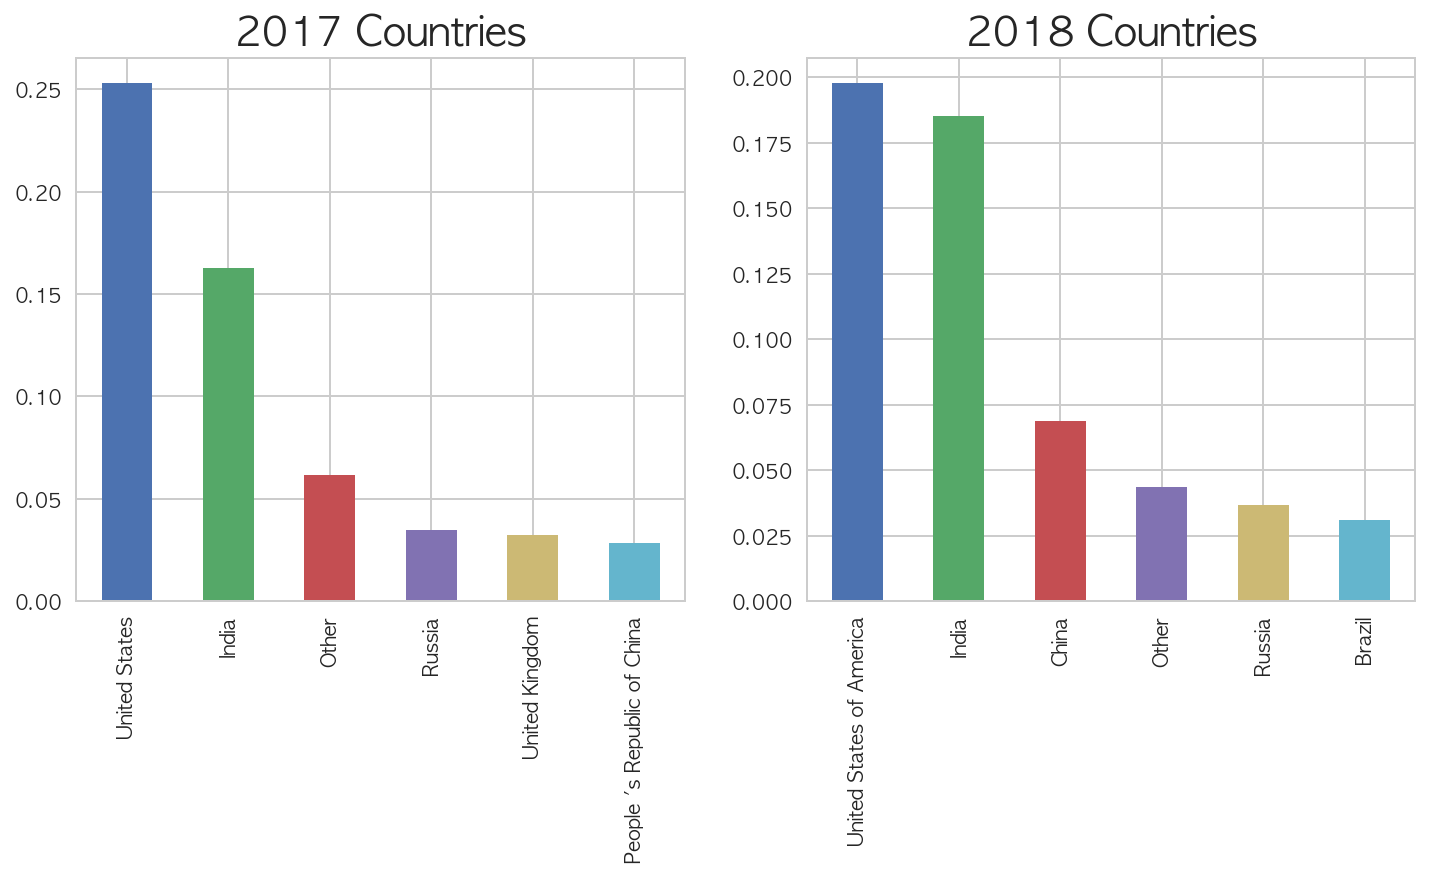

In [38]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
per_df(tmp_df, tmp_df.columns[1])[:6].plot.bar(ax=ax[0]).set_title('2017 Countries', fontdict=fontdict)
per_df(multi_18, 'Q3')[:6].plot.bar(ax=ax[1]).set_title('2018 Countries', fontdict=fontdict)

Text(0.5,1,'2018 Countries')

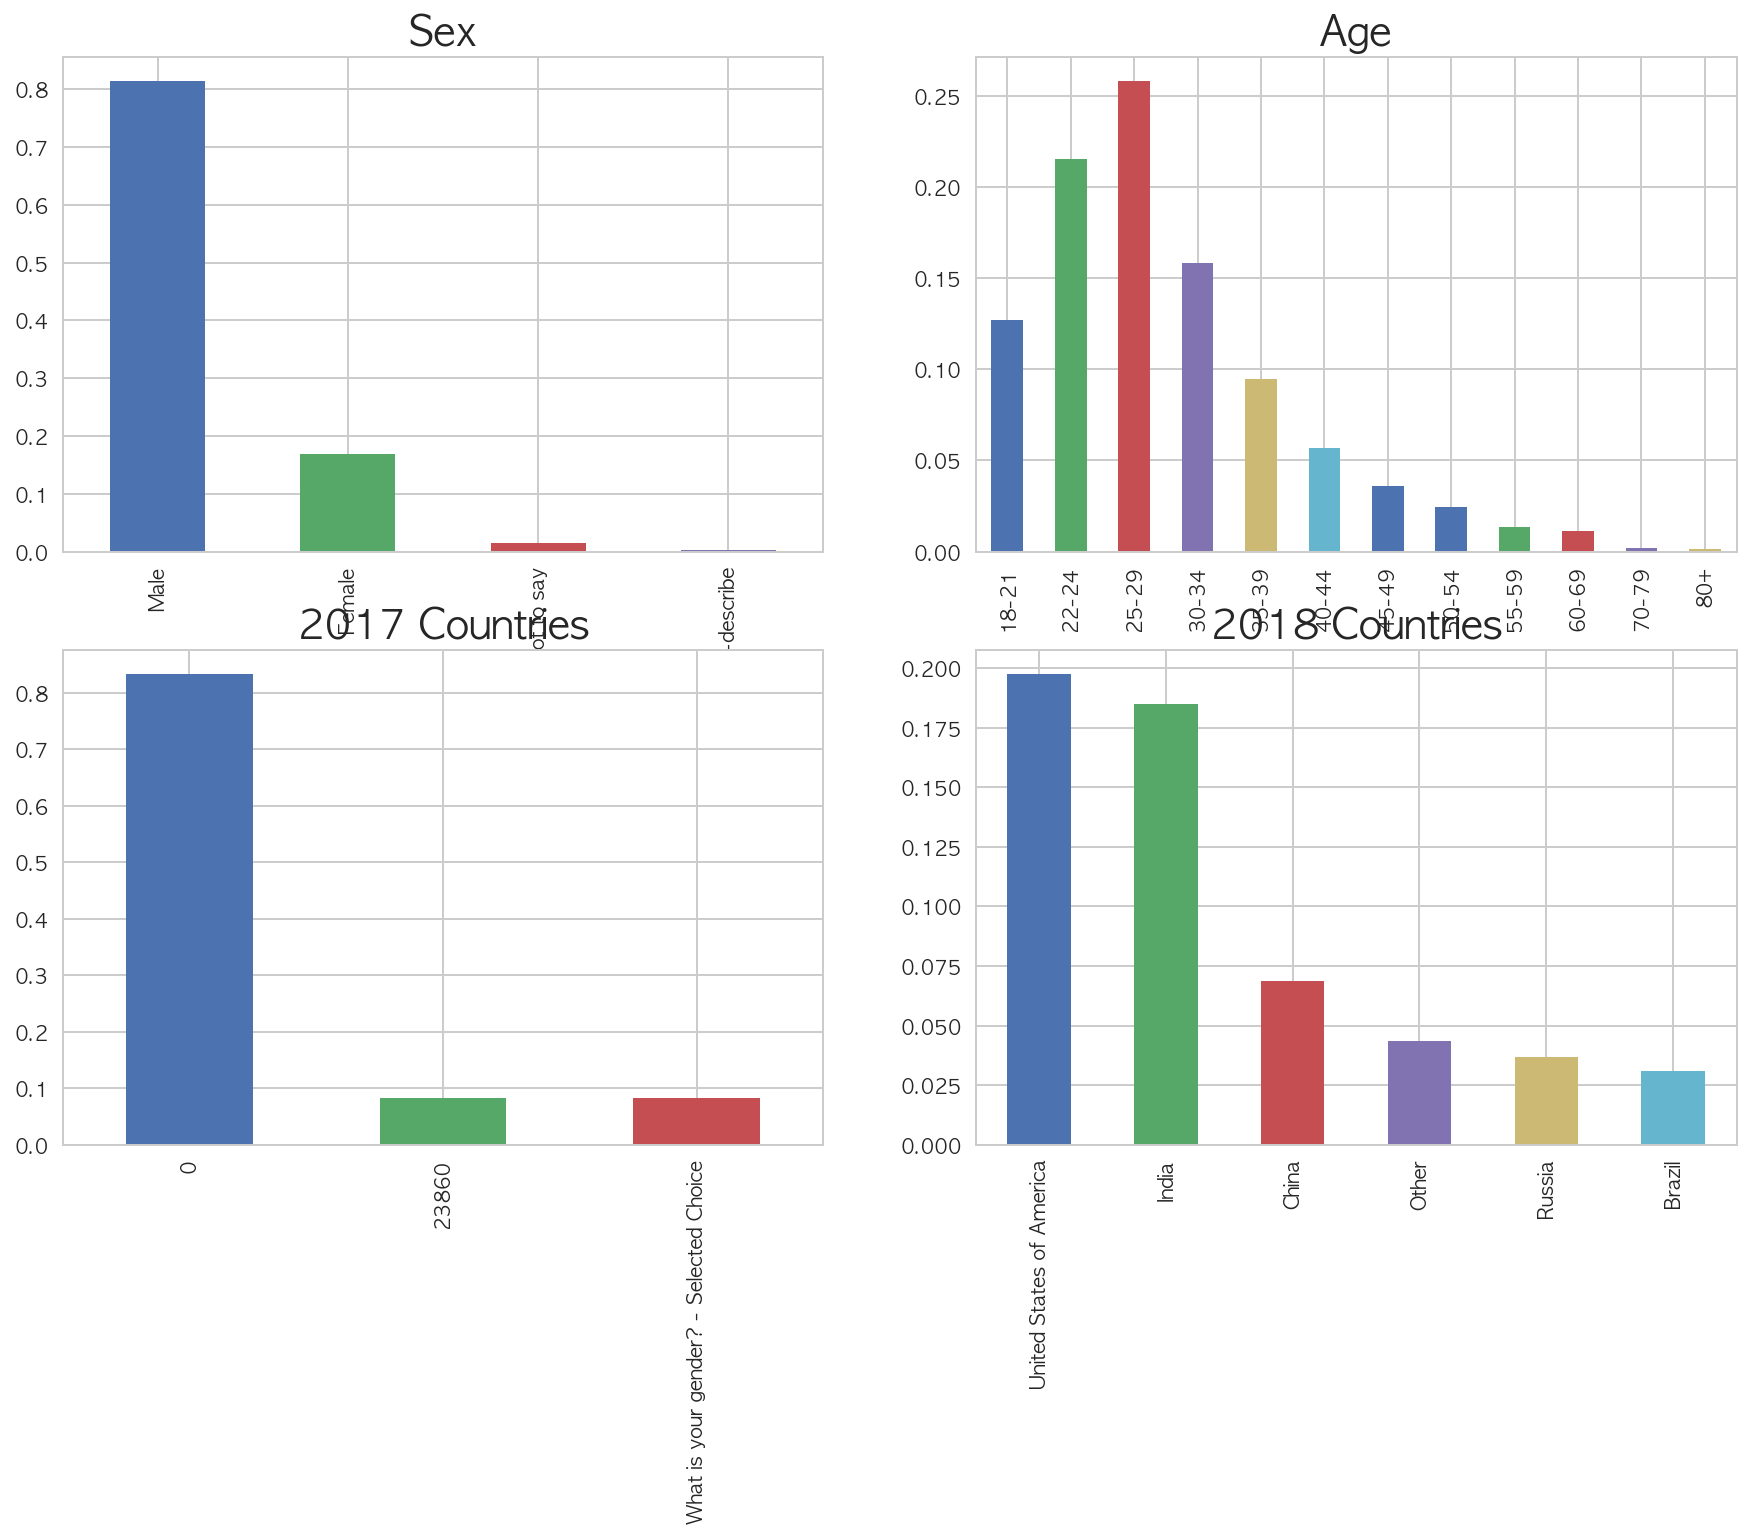

In [320]:
f, ax = plt.subplots(2,2, figsize=(15, 10), squeeze=True)
per_df(multi_18, 'Q1').plot.bar(ax=ax[0, 0]).set_title('Sex', fontdict=fontdict)
per_df(multi_18, 'Q2').sort_index().plot.bar(ax=ax[0, 1]).set_title('Age', fontdict=fontdict)
per_df(tmp_df, tmp_df.columns[1])[:6].plot.bar(ax=ax[1, 0]).set_title('2017 Countries', fontdict=fontdict)
per_df(multi_18, 'Q3')[:6].plot.bar(ax=ax[1, 1]).set_title('2018 Countries', fontdict=fontdict)

In [240]:
# multi_18_f = multi_18[multi_18["Q1"] == "Female"]
# multi_18_m = multi_18[multi_18["Q1"] == "Male"]
# multi_18_n = multi_18[(multi_18["Q1"] != "Male") & (multi_18["Q1"] != "Female")]

In [44]:
multi_18_US = get_df_i_want(multi_18, "Q3", "United States of America")
multi_18_India = get_df_i_want(multi_18, "Q3", "India")
multi_18_China = get_df_i_want(multi_18, "Q3", "China")

In [255]:
def draw_plot(dfs_, q_df, q, is_need_other = False):
    is_single_choice_question = q_df.loc[q]["is_single"]
    dfs_keys = list(dfs_.keys())
    dfs = dfs_.values()
    if is_single_choice_question:
        get_question(q_df, q)
        q = "Q" + str(q)
        length_of_dfs = len(dfs)
        plt.figure(figsize=(5*length_of_dfs, 5))
        order_li = []
        for idx, df in enumerate(dfs):
            if idx == 0:
                order_li = [str_ for str_ in df[q].unique().tolist() if type(str_) != float]
            plt.subplot(1, length_of_dfs, idx + 1)
            plt.xticks(rotation=90)
            plt.title(dfs_keys[idx], fontdict = fontdict)
            sns.countplot(df[q].sort_index(), order = order_li)
        plt.show()
    else:
        order_li = get_question(q_df, q, is_need_display_order=True)
        cols = [
            q for q in get_selections_of_multiple_choice_question(q) if "_OTHER_TEXT" not in q
        ] 
        for idx, df in enumerate(dfs):
            for col in cols:
                uq_li = df[col].unique().tolist()
                print(dfs_keys[idx], col, "Total Length :", len(df[col]))
                print(dfs_keys[idx], col, uq_li[0], "Length :", len(df[df[col] == uq_li[0]]))

In [229]:
dfs = {
    "US" : multi_18_US, 
    "India" : multi_18_India, 
    "China" : multi_18_China
}

Q10. Does your current employer incorporate machine learning methods into their business?


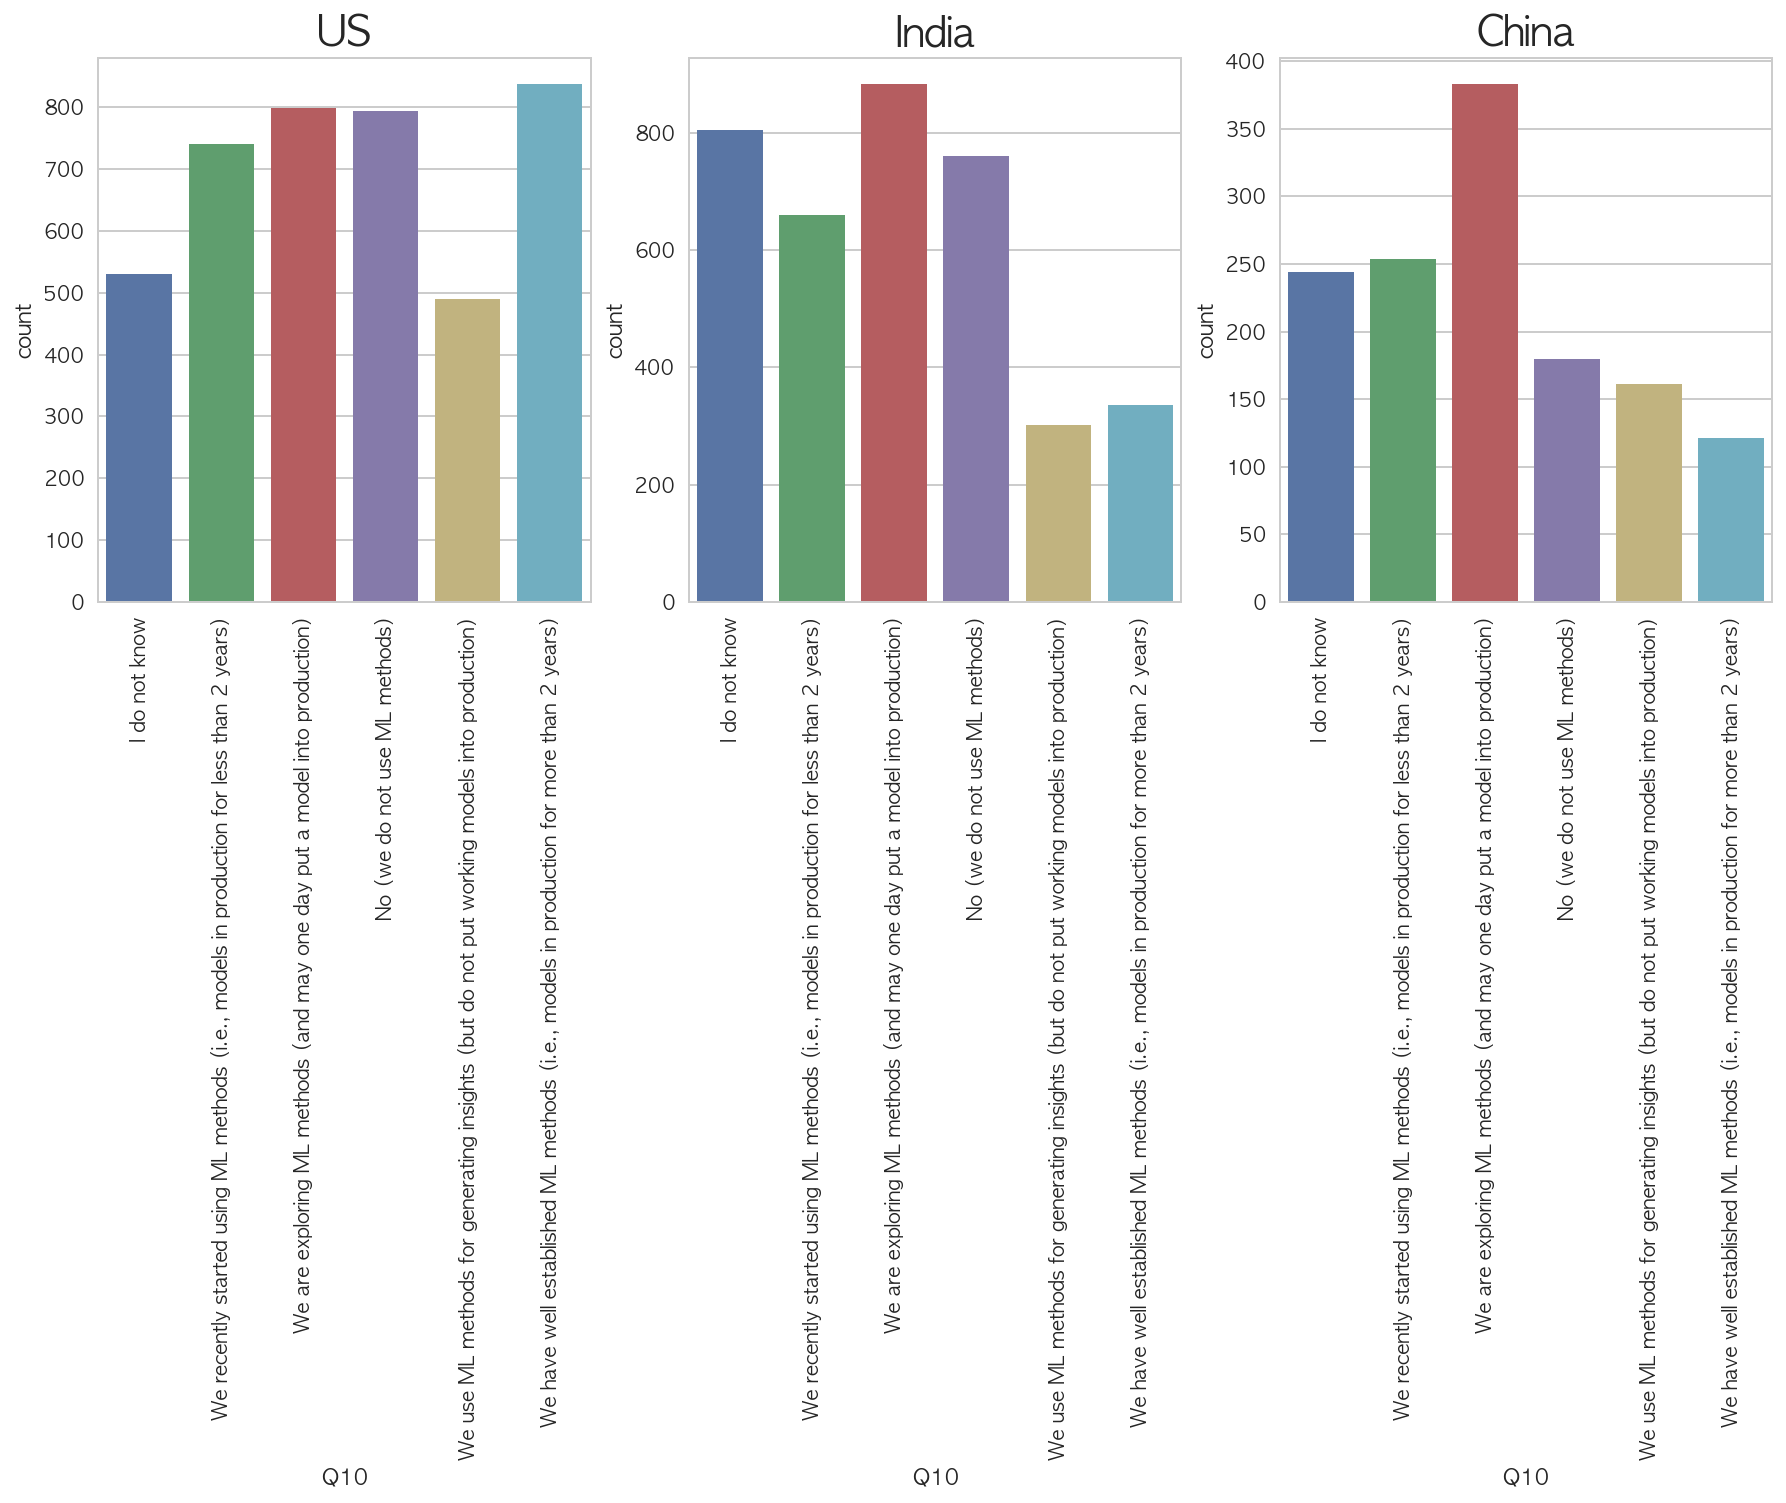

In [262]:
draw_plot(dfs, q_df, 10)

In [275]:
print_question(2018, "Q11_Part_1", is_survey_schema=True)

KeyError: 'Q11_Part_1'

In [274]:
print_question(2018, "Q11_Part_1", is_survey_schema=False)

Q11_Part_1
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions


In [300]:
get_question(q_df, 35)

Q35. What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) 
  1. taught


IndexError: list index out of range